## Wordfish
Wordfishはテキストの系列から極性の変化を発見することのできる教師なし学習の統計モデルであり、ポアソン分布に基づいた生成モデルになっている。

$y_{ivt}$ を政党$i$が時刻$t$のテキスト(たとえば選挙時の公約)で単語$v$を使った頻度とすると、観測値$Y=\{y_{ivt}\}_{i,v,t}$について, Wordfishは次の確率を最大化するパラメータ$(\alpha, \beta, \theta, \phi)$を求める。

$$
\left\{
\begin{align}
p(Y) &= \prod_i\prod_t\prod_v Po (y_{ivt}|\lambda_{ivt}) \\
\lambda_{ivt} &= \exp(\alpha_{it} + \beta_{v} + \phi_{v} \cdot \theta_{it})
\end{align}
\right.
$$

$\alpha_{it}$は、テキスト$it$ での固定効果、$\beta_{v}$は、単語$v$の固定効果。  
興味があるのは、単語$v$の極性軸上での位置$\phi_v$と政党$i$の時刻$t$での潜在位置$\theta_{it}$となる。

これは、単語頻度$y_{ivt}$の期待値は、テキスト$it$と単語$v$で決まるベースライン$\alpha_{it} + \beta_{v}$を、政党の持つ極性$\theta_{it}$と単語の持つ極性$\phi_{v}$で上下して決まるという事を表している。

$\theta$と$\phi$の極性が同じとき、例えば  
$\theta_{it}>0$が右翼を表す場合は、単語$v$(たとえば軍備)の位置も同様に$\phi_v>0$  
$\theta_{it}<0$が左翼を表す場合は、単語$v$(たとえば社会保障)の位置も同様に$\phi_v<0$  
の時に期待値は増加し、$\theta$と$\phi$の極性が異なる時に期待値は減少するモデルになっている。

パラメータ$(\alpha, \beta, \theta, \phi)$の推定は、EMアルゴリズム（最尤法）で行う。  

## Wordfish の課題
- 極性軸が分析の目的に対応しているか不明
- 単語の頻度を説明するモデルでテキストの長さに依存している
- 分析対象のテキストを選択するための方法がない
- スパースな文書単語行列だと推定が収束しない
- コーパスの前処理（分析者のヒューリスティック）で結構結果が変わる

## チュートリアル
quanteda: https://tutorials.quanteda.io/machine-learning/wordfish/

In [1]:
#| warning: false

# Wordfish is a Poisson scaling model of one-dimensional document positions (Slapin and Proksch 2008). Wordfish also allows for scaling documents, but in comparison to Wordscores, reference scores/texts are not required. Wordfish is an unsupervised one-dimensional text scaling method, meaning that it estimates the positions of documents solely based on the observed word frequencies.
library(quanteda)
library(quanteda.textmodels)
library(quanteda.textplots)
library(quanteda.textstats)

library(tidyverse)
library(ggplot2)

Package version: 4.3.1
Unicode version: 14.0
ICU version: 70.1

Parallel computing: disabled

See https://quanteda.io for tutorials and examples.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 例1. 2010年のアイルランドの予算演説

In [2]:
#| warning: false

# In this example, we show how to apply Wordfish to the Irish budget speeches from 2010. First, we create a document-feature matrix. Afterwards, we run Wordfish.
wf <- data_corpus_irishbudget2010 %>% 
  tokens(remove_punct = TRUE) %>% 
  dfm() %>% 
  textmodel_wordfish(dir = c(6, 5))

In [3]:
smr <- summary(wf)

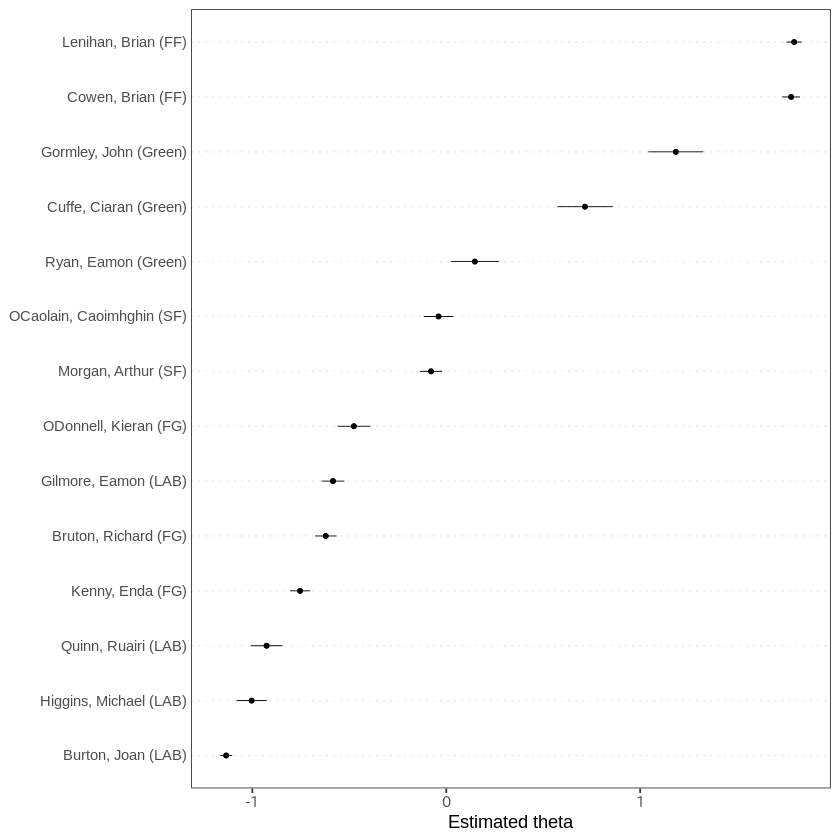

In [4]:
# We can plot the results of a fitted scaling model using textplot_scale1d().
textplot_scale1d(wf)

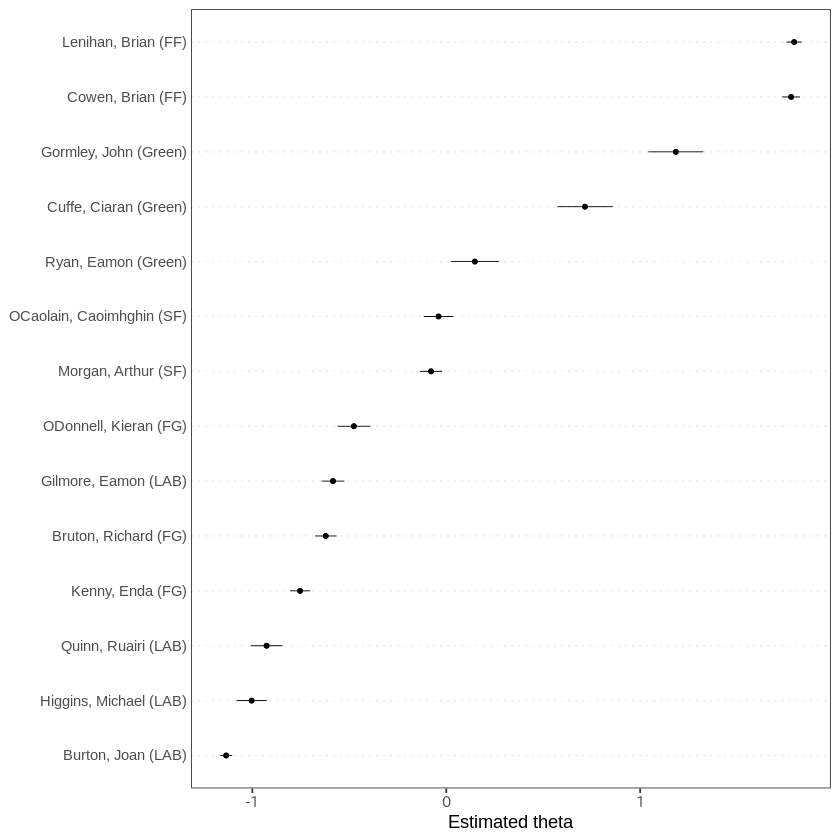

In [5]:
# The function also allows to plot scores by a grouping variable, in this case the party affiliation of the speakers.
textplot_scale1d(wf, groups = wf$party)

**$\theta$ 上位演説の冒頭部分**

In [6]:
for (i in order(-smr$estimated.document.positions$theta)) {
  cat(paste('[', names(data_corpus_irishbudget2010)[i], ']',
            'θ =', 
            smr$estimated.document.positions$theta[i],
            '\n',
            str_split(data_corpus_irishbudget2010[i], '\\n\\n')[[1]][1],
            '\n ..... \n\n'))
}

[ Lenihan, Brian (FF) ] θ = 1.79403208978541 
 When I presented the supplementary budget to this House last April, I said we could work our way through this period of severe economic distress. Today, I can report that notwithstanding the difficulties of the past eight months, we are now on the road to economic recovery. 
 ..... 

[ Cowen, Brian (FF) ] θ = 1.77845687266213 
 This country has to address probably the biggest challenge to its economic independence it has ever had to face, even though this is now in the context of our membership of the EU and the Eurozone. The budget will demonstrate to ourselves and to others that we are succeeding in mastering the challenge. It is no time for half-measures, evasion or long-fingering. While others can suggest and propose, or oppose, the Government has the responsibility with the support of the Dáil for taking the measures that the public interest requires at this time. Even in these most difficult financial circumstances, we need to keep m

**単語の極性軸上での推定位置$\phi$**

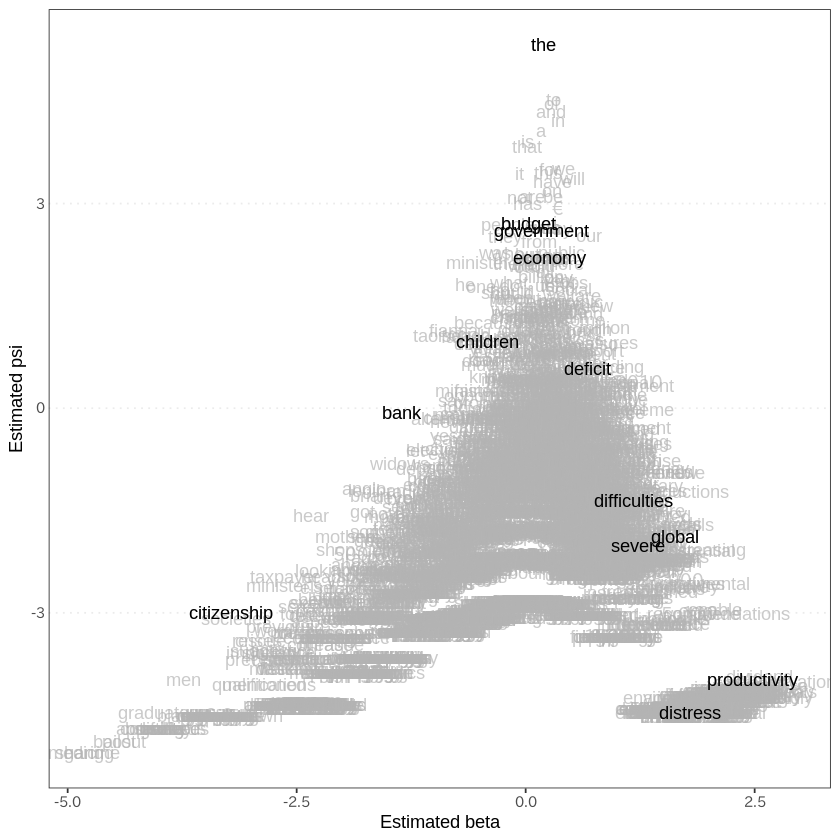

In [7]:
# Finally, we can plot the estimated word positions and highlight certain features.
textplot_scale1d(wf, margin = "features", 
                 highlighted = c("government", "global", "children", "distress", "severe",
                                 "bank", "economy", "the", "citizenship", "difficulties",
                                 "productivity", "deficit", "budget"))

**$\theta$ 上位単語**

In [8]:
for (i in order(-smr$estimated.feature.scores$psi)[1:10]) {
  cat(paste(smr$estimated.feature.scores$psi[i], dimnames(smr$estimated.feature.scores)[[1]][i], '\n'))
}

5.33077612037296 the 
4.51895963991204 to 
4.4655629835409 of 
3.83785434621164 that 
3.51245027118319 we 
3.46033786939103 this 
2.72393888384118 i 
2.70992764088605 budget 
2.52775193871813 our 
1.62406307643945 when 


**$\theta$ 下位単語**

In [9]:
for (i in order(smr$estimated.feature.scores$psi)[1:10]) {
  cat(paste(smr$estimated.feature.scores$psi[i], dimnames(smr$estimated.feature.scores)[[1]][i], '\n'))
}

-4.45588298830556 distress 
-4.45588298830556 notwithstanding 
-2.01279091023759 severe 
-1.79579750189062 presented 
-1.35674335564437 difficulties 
-1.13356117611894 supplementary 
-0.57254819007261 april 
-0.451443472398262 said 
-0.246611687636502 report 
-0.177881205551863 period 


### 例2. 2016年の大統領選挙に関する朝日新聞の記事
2016年の朝日新聞記事のうちトランプに関連する記事を日単位でグルーピングして尺度を推定してみたもの

In [10]:
load('../data/data_corpus_asahi_2016.rda')

corpus <- corpus_trim(data_corpus_asahi_2016, exclude_pattern = "^(?!.*トランプ).*$")

toks <- corpus %>% 
  tokens(remove_punct = TRUE)

mx_trump <- toks %>% 
  dfm() %>% 
  dfm_remove(pattern = 'トランプ', valuetype = 'fixed') %>%
  dfm_remove(pattern = 'ドナルド', valuetype = 'fixed') %>%
  dfm_select(min_nchar = 2) %>% 
  dfm_remove('^[ぁ-ん]+$', valuetype = 'regex', min_nchar = 2) %>% 
  dfm_trim(min_docfreq = 3) %>% 
  dfm_subset(date >= '2016-01-01')

date <- seq(as.Date('2016-01-01'), as.Date('2016-12-31'), by = '1 day')

mx_trump <- mx_trump %>% 
  dfm_group(factor(docvars(mx_trump, 'date'), levels = as.factor(unique(date))), fill = FALSE)

mx_trump <- mx_trump[order(docnames(mx_trump)),]
mx_trump

wf_trump <- textmodel_wordfish(mx_trump)
result <- summary(wf_trump)

Document-feature matrix of: 259 documents, 2,296 features (96.22% sparse) and 3 docvars.
            features
docs         米国 共和 大統領 候補 選び イスラム教 入国 禁止 放言 続ける
  2016-01-01    1    2      2    1    1          2    1    1    1      1
  2016-01-04    0    0      1    0    0          0    0    0    0      0
  2016-01-10    0    1      1    1    0          1    1    1    0      0
  2016-01-11    0    1      1    1    0          1    1    1    0      0
  2016-01-13    0    1      1    0    0          1    1    1    0      0
  2016-01-14    2    3      5    1    0          2    2    2    0      0
[ reached max_ndoc ... 253 more documents, reached max_nfeat ... 2,286 more features ]

**文書の極性軸上での推定位置$\theta$の推移**

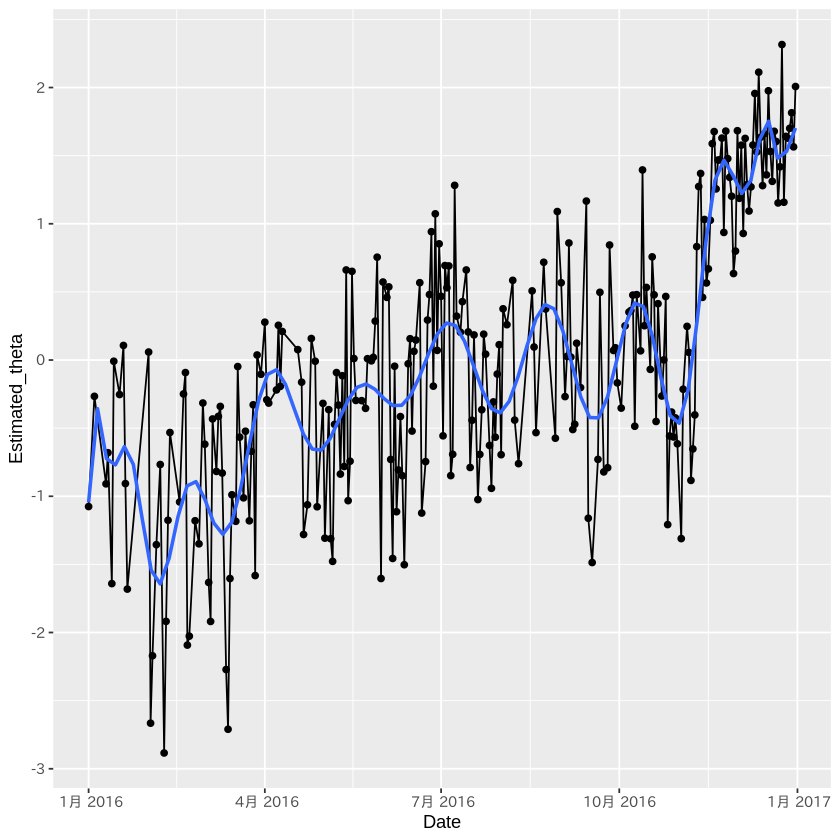

In [11]:
trump_theta = tibble(
  Date = as.Date(names(which(ntoken(mx_trump) > 0))),
  Estimated_theta = result$estimated.document.positions$theta
)

ggplot(data = trump_theta, mapping = aes(x = Date, y = Estimated_theta)) +
  geom_point() +
  geom_line() +
  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = FALSE)

**θ の上位記事**

In [12]:
for (i in order(-result$estimated.document.positions$theta)[1:5]) {
  print(result$estimated.document.positions$theta[i])
  print(as.character(corpus[i]))
}

[1] 2.315487
                                                                                                                                                                                                                                                                                                                              text9984 
"共和党の大統領候補のトランプ氏（７０）が、政治経験のなさを売りに変革を訴えるのに対し、政治経験が長い実務家のケーン氏の起用で「安定感」を強調する選択となった。  トランプ氏を「不安定で、大統領をまかせられない」と批判しているだけに、安定感を重視したとみられる。  トランプ陣営は、ケーン氏が知事時代に受け取っていた献金を問題視。" 
[1] 2.11261
                                                                                                                                                          text9824 
"秋の大統領選で共和党の候補者指名を確実にしているトランプ氏はフェイスブックで「何人の警察官と人々が指導力の欠如によって死亡しなければならないのか」と発信した。（" 
[1] 2.007497
                                                                                                                                                                                                                          

**θ の下位記事**

In [13]:
for (i in order(result$estimated.document.positions$theta)[1:5]) {
  print(result$estimated.document.positions$theta[i])
  print(as.character(corpus[i]))
}

[1] -2.884383
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text1302 
"全米規模で支持率首位の民主党・クリントン前国務長官と共和党・トランプ氏だが、初戦となる同州では共に党内のライバル候補と激しく競り合い、予断を許さない情勢だ。  一方、８年ぶりの政権奪還を目指す共和党は、党の主流派に対して「アウトサイダー」と呼ばれる不動産王のトランプ氏と、保守強硬派のクルーズ上院議員が支持率上位を占める。  トランプ氏は不法移民排斥やイスラム教徒の一時入国禁止などを唱え、首位を独走。  初戦のアイオワ州党員集会では、デモイン・レジスターの世論調査でクルーズ氏がトランプ氏に５ポイント差まで迫る勢いを見せ、クルーズ氏は「トランプ氏がアイオワで勝利すれば、勢いが止められなくなる」と阻止を狙う。" 
[1] -2.710242
                                                       

**単語の極性軸上での推定位置$\phi$**

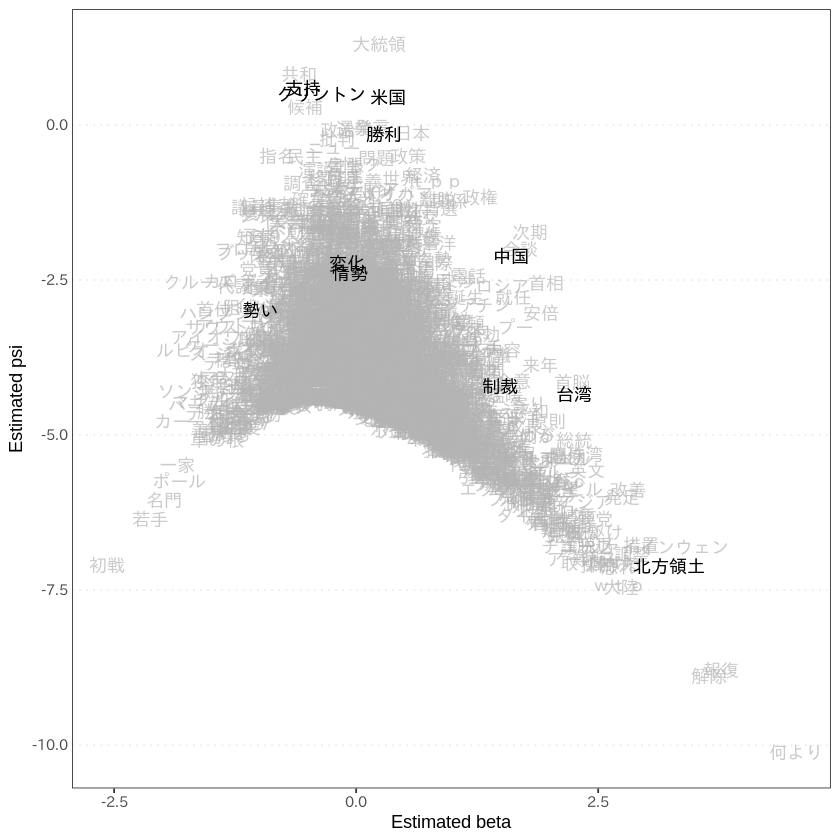

In [14]:
textplot_scale1d(wf_trump, margin = "features", 
                 highlighted = c("クリントン", "情勢", "米国", "勢い", "変化", "支持",
                                 "勝利", "中国", "制裁", "台湾", "北方領土"))

**Φ の上位単語**

In [15]:
for (i in order(-result$estimated.feature.scores$psi)[1:20]) {
  print(paste(result$estimated.feature.scores$psi[i], dimnames(result$estimated.feature.scores)[[1]][i]))
}

[1] "1.29564454187802 大統領"
[1] "0.811835555505852 共和"
[1] "0.579579928291255 支持"
[1] "0.438477210553349 米国"
[1] "0.283455573528847 候補"
[1] "-0.0925536161365787 政治"
[1] "-0.85561756056355 移民"
[1] "-1.30760026790359 経験"
[1] "-1.40094350605391 メキシコ"
[1] "-1.55472254488566 実業"
[1] "-1.56248904639838 イスラム教"
[1] "-1.76589351035601 人気"
[1] "-1.98313565347919 注目"
[1] "-2.0773825487873 自ら"
[1] "-2.2220932721953 トップ"
[1] "-2.30868080697153 入国"
[1] "-2.32297894528721 禁止"
[1] "-2.43646548270979 予想"
[1] "-2.5863114993852 今年"
[1] "-2.61627094566761 走る"


**Φ の下位単語**

In [16]:
for (i in order(result$estimated.feature.scores$psi)[1:20]) {
  print(paste(result$estimated.feature.scores$psi[i], dimnames(result$estimated.feature.scores)[[1]][i]))
}

[1] "-4.69189184976002 衰え"
[1] "-4.39725639848841 乏しい"
[1] "-4.38274965230382 実際は"
[1] "-4.14448325537196 放言"
[1] "-3.39900970265148 右翼"
[1] "-3.04151415292784 過激派"
[1] "-2.92754388365127 選び"
[1] "-2.81370608952886 当初"
[1] "-2.80140313207378 続ける"
[1] "-2.71265748258171 有力"
[1] "-2.61627094566761 走る"
[1] "-2.5863114993852 今年"
[1] "-2.43646548270979 予想"
[1] "-2.32297894528721 禁止"
[1] "-2.30868080697153 入国"
[1] "-2.2220932721953 トップ"
[1] "-2.0773825487873 自ら"
[1] "-1.98313565347919 注目"
[1] "-1.76589351035601 人気"
[1] "-1.56248904639838 イスラム教"


**トランプとクリントンの $\theta$ の推移比較**

In [17]:
mx <- corpus_trim(data_corpus_asahi_2016, exclude_pattern = "^(?!.*クリントン).*$") %>% 
  tokens(remove_punct = TRUE) %>% 
  dfm() %>% 
  dfm_remove(pattern = 'クリントン', valuetype = 'fixed') %>%
  dfm_select(min_nchar = 2) %>% 
  dfm_remove('^[ぁ-ん]+$', valuetype = 'regex', min_nchar = 2) %>% 
  dfm_trim(min_docfreq = 3) %>% 
  dfm_subset(date >= '2016-01-01')

mx <- mx %>% 
  dfm_group(factor(docvars(mx, 'date'), levels = as.factor(unique(date))), fill = FALSE)

mx <- mx[order(docnames(mx)),]
mx

result <- mx %>% 
  textmodel_wordfish() %>% 
  summary()

theta = tibble(
  Date = as.Date(names(which(ntoken(mx) > 0))),
  Estimated_theta = result$estimated.document.positions$theta
)

#ggplot(data = theta, mapping = aes(x = Date, y = Estimated_theta)) +
#  geom_point() +
#  geom_line() +
#  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = FALSE)

trump <- trump_theta %>% 
  add_column(Who="Trump")


clinton <- theta %>% 
  add_column(Who="Clinton")

Document-feature matrix of: 199 documents, 929 features (95.83% sparse) and 3 docvars.
            features
docs         民主 ヒラリー 国務 長官 優位 立つ 問題 共和 米国 大統領
  2016-01-04    1        1    1    1    1    1    1    1    0      0
  2016-01-05    1        1    0    0    0    0    0    0    1      1
  2016-01-08    0        1    0    0    0    0    1    0    0      1
  2016-01-10    1        0    1    1    0    0    0    1    0      0
  2016-01-17    0        1    0    0    0    0    0    0    0      2
  2016-01-19    0        1    1    1    1    0    0    1    0      3
[ reached max_ndoc ... 193 more documents, reached max_nfeat ... 919 more features ]

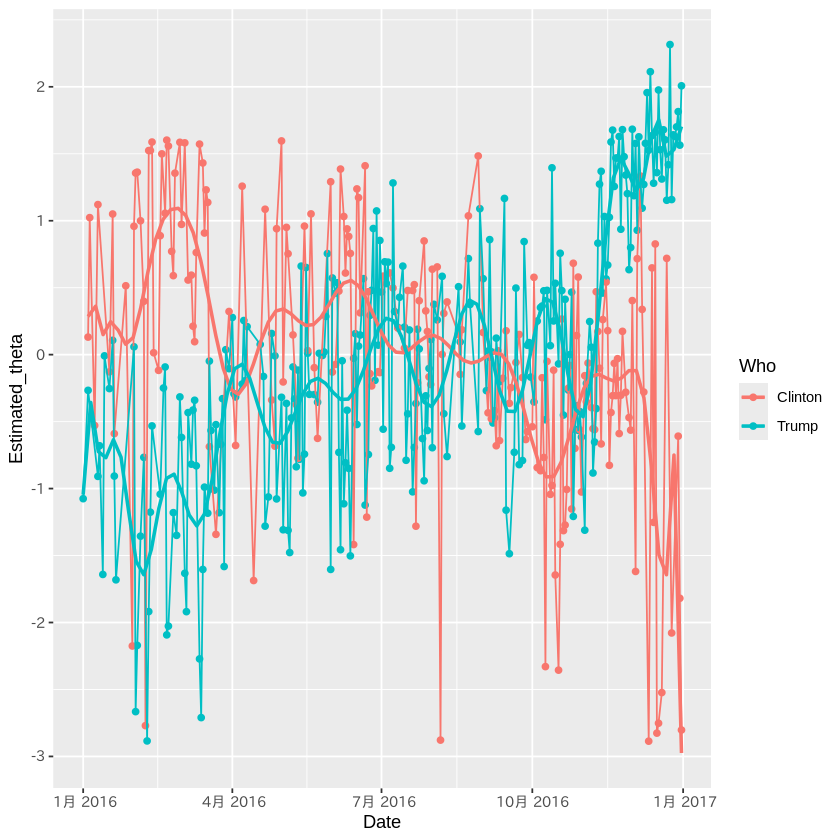

In [18]:
ggplot(data = rbind(trump, clinton),
       mapping = aes(x = Date, y = Estimated_theta, group = Who)) +
  geom_point(mapping = aes(colour = Who)) +
  geom_line(mapping = aes(colour = Who)) +
  stat_smooth(method = "lm", formula = y ~ poly(x, 24), se = FALSE, mapping = aes(colour = Who))

**[参考] 単語極性辞書を用いた単純なポジネガ比の推移**

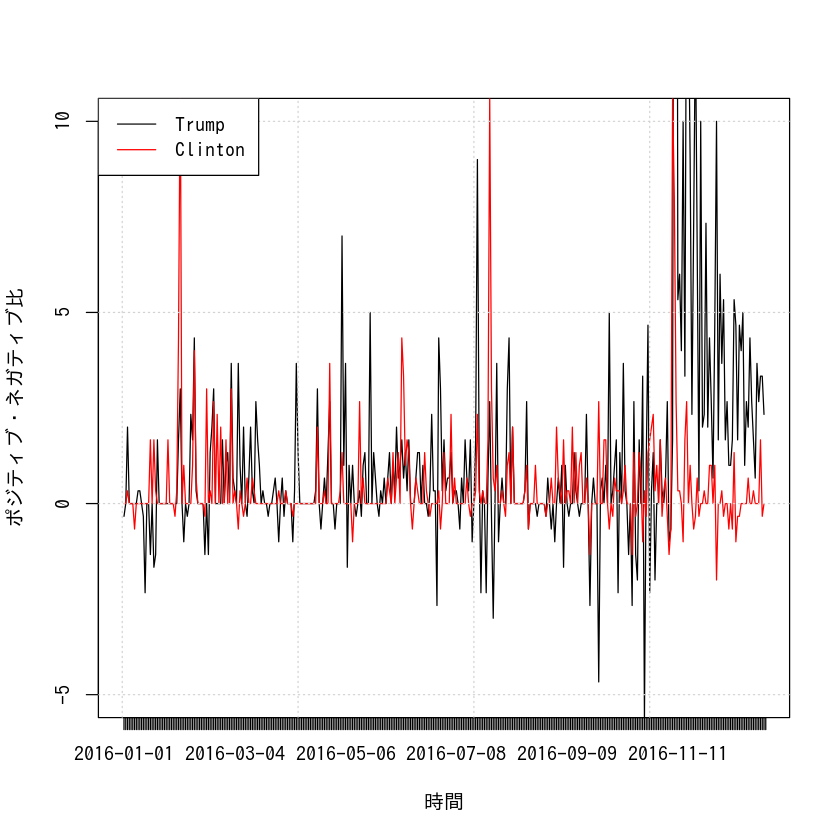

In [19]:
toks <- data_corpus_asahi_2016 %>% 
  tokens(remove_punct = TRUE)

mx <- toks %>% 
  dfm() %>%
  dfm_select(min_nchar = 2) %>%
  dfm_remove('^[ぁ-ん]+$', valuetype = 'regex') %>% 
  dfm_trim(min_termfreq = 5)

dict <- dictionary(file = './extra/higashiyama_sentiment.yml')

date <- seq(as.Date('2016-01-01'), as.Date('2016-12-31'), by = '1 day')
toks_trump <- tokens_select(toks, "トランプ", window = 10)
mx_trump <- dfm(toks_trump)
mx_trump <- dfm_lookup(mx_trump, dictionary = dict, nomatch = 'none')
mx_trump <- dfm_group(mx_trump, factor(docvars(mx_trump, 'date'), levels = as.factor(unique(date))), fill = TRUE) # 
mx_trump <- mx_trump[order(docnames(mx_trump)),]

toks_clinton <- tokens_select(toks, "クリントン", window = 10)
mx_clinton <- dfm(toks_clinton)
mx_clinton <- dfm_lookup(mx_clinton, dictionary = dict, nomatch = 'none')
mx_clinton <- dfm_group(mx_clinton, factor(docvars(mx_clinton, 'date'), levels = as.factor(unique(date))), fill = TRUE) # 
mx_clinton <- mx_clinton[order(docnames(mx_clinton)),]

par(family="IPAGothic")
plot((mx_trump[,'positive'] - mx_trump[,'negative']) / nfeat(mx_trump), type = 'l', 
     xaxt = 'n', ylab = 'ポジティブ・ネガティブ比', xlab = '時間', ylim = c(-5, 10))
lines((mx_clinton[,'positive'] - mx_clinton[,'negative']) / nfeat(mx_clinton), col = 'red')
axis(1, at = 1:366, seq.Date(as.Date('2016-01-01'), as.Date('2016-12-31'), 'days'))
grid()
legend('topleft', col = c('black', 'red'), legend = c('Trump', 'Clinton'), lty = 1)